<a href="https://colab.research.google.com/github/fataltes/quickNBs/blob/master/lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet

     |████████████████████████████████| 55.0MB 74kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random
from sklearn.linear_model import LinearRegression

Example initialization

In [83]:
n = 100
X = np.random.uniform(-10,10, n) 
noise = np.random.normal(0, 0.1, n) 
true_w, true_b = -1, 2

y = true_w * X + true_b + noise  

Simple gradient deescent

In [84]:
def gradient_descent(X, y, w, b, learning_rate):
    dw = -2 * np.sum(X * (y - w * X - b)) # ∂e/∂w
    db = -2 * np.sum(y - w * X - b)       # ∂e/∂b
    w_new = w - learning_rate * dw        # minus sign since we are minizing
    b_new = b - learning_rate * db
    return w_new, b_new

def get_loss(X,y,w,b):
    return (y - w * X - b).T @ (y - w * X - b)   # square loss, 
    # .T and @ denote transpose and matrix multiplication resp.
    

learning_rate = 0.0001
max_epoch = 500
w, b = -1,3

for epoch in range(1,max_epoch+1):
    w,b = gradient_descent(X, y, w, b, learning_rate)
    
    if epoch % 50 == 0:
        print(f'{get_loss(X,y,w,b):.0f}')

if b > 0:
    print(f'y = {w:.2f} x + {b:.2f}')
else:
    print(f'y = {w:.2f} x - {-b:.2f}')

14
2
1
1
1
1
1
1
1
1
y = -1.00 x + 2.01


Adam

In [85]:
# Adam
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        g = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * g
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)
        param[:] = param - div



mx.random.seed(1)
random.seed(1)

# Generate data.
num_inputs = 1
num_examples = 100
true_w = [-1]
true_b = 2
X2 = np.reshape(X, (num_examples, num_inputs))
ndX = nd.array(X2)
ndy = nd.array(y)
dataset = gluon.data.ArrayDataset(ndX, ndy)

# Construct data iterator.
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, ndX.take(j), ndy.take(j)

# Initialize model parameters.
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    sqrs = []
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())
    return params, vs, sqrs

# Linear regression.
def net(X, w, b):
    return nd.dot(X, w) + b

# Loss function.
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

In [77]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs, sqrs = init_params()
    total_loss = [np.mean(square_loss(net(ndX, w, b), ndy).asnumpy())]

    t = 0
    # Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            # Increment t before invoking adam.
            t += 1
            adam([w, b], vs, sqrs, lr, batch_size, t)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(ndX, w, b), ndy).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    return (np.reshape(w.asnumpy(), (1, -1)), b.asnumpy()[0])

Batch size 10, Learning rate 0.100000, Epoch 1, loss 8.4357e-01
Batch size 10, Learning rate 0.100000, Epoch 2, loss 1.8208e-01
Batch size 10, Learning rate 0.100000, Epoch 3, loss 7.6206e-02
w: [[-1.0603776]] b: 2.1943483 



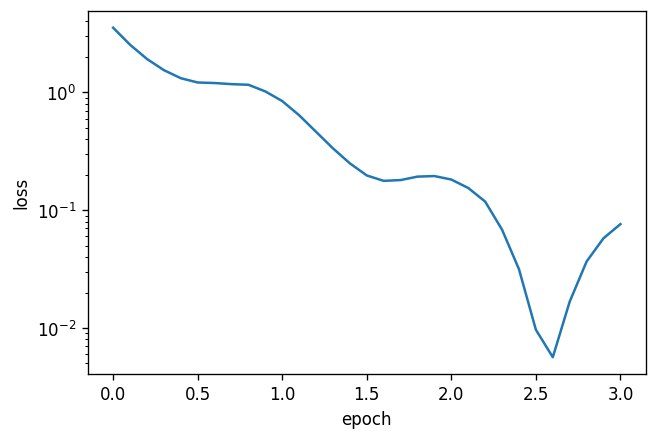

In [86]:
rt = train(batch_size=10, lr=0.1, epochs=3, period=10)

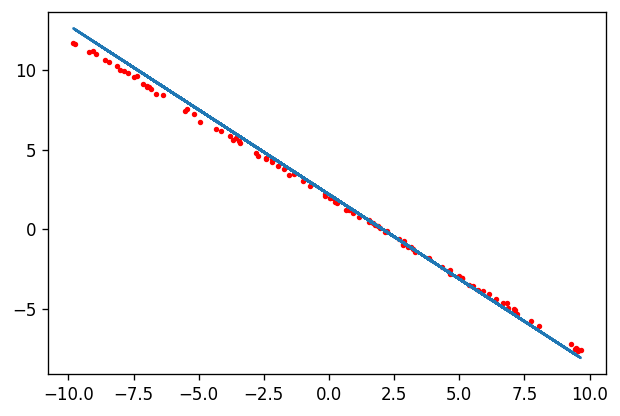

In [91]:
plt.scatter(X, y, s=5, color="r")
plt.plot(X, rt[0][:,0]*X+rt[1])